## Analyze the whole-brain voxel-wise GLM results

The numbering of the first-level COPEs:

- 8 basic contrasts:
    1. stim_easy
    2. stim_hard
    3. cue_left
    4. cue_right
    5. cue_neutral
    6. response_left
    7. response_right
    8. error
- `cue`, `stim`, `response`:
    9. cue
    10. stim
    11. response
- The actual constrasts of interest:
    12. Cue payoff - cue neutral (= (cue_left + cue_right) - 2\*cue_neutral)
    13. stim_hard - stim_easy
    14. Response left - response right
    15. Cue left - cue right

The numbering of the third-level COPEs:
1. Intercept positive
2. Dataset
3. Covariate z_shift
4. Covariate v_shift
5. Intercept negative
6. Dataset negative
7. Covariate z_shift negative
8. Covariate v_shift negative

In [37]:
first_level_copes = {'stim_easy': 1,
                     'stim_hard': 2,
                     'cue_left': 3,
                     'cue_right': 4,
                     'cue_neutral': 5,
                     'response_left': 6,
                     'response_right': 7,
                     'error': 8,
                     'cue': 9,
                     'stim': 10,
                     'response': 11,
                     'cue_payoff - cue_neutral': 12,
                     'stim_hard - stim_easy': 13,
                     'response_left - response_right': 14,
                     'cue_left - cue_right': 15}

second_level_copes = {'intercept': 1,
                      'dataset': 2,
                      'z_shift': 3,
                      'v_shift': 4,
                      'v_shift_bias': 5,
                      '-intercept': 6,
                      '-dataset': 7,
                      '-z_shift': 8,
                      '-v_shift': 9,
                      '-v_shift_bias': 10}

In [38]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

In [39]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

In [40]:
def get_second_level_zmap(first_level_contrast, second_level_contrast, thresholding=None, 
                          base_dir='./derivatives/both/glm_level3'):
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]

    gfeat_dir = os.path.join(base_dir, 'cope{}.gfeat').format(cope1)
    
    if thresholding is None:
        nii = nib.load(os.path.join(gfeat_dir, 'cope1.feat', 'stats', 'zstat{}.nii.gz').format(cope2))
        threshold = 0
    elif thresholding == 'fwer' or thresholding == 'cluster':
        nii_pos = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(cope2)
        neg_contrast = cope2+5
        nii_neg = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(neg_contrast)
        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nib.load(nii_pos).get_data())
        
    elif thresholding == 'fdr':
        nii = nib.load(os.path.join(gfeat_dir, 'cope1.feat', 'stats', 'zstat{}.nii.gz').format(cope2))
        _, threshold = map_threshold(nii, alpha=0.05, height_control='fdr')

    return nii, threshold

In [41]:
def plot_4x4(z_map, n_cuts=16, **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)
    
    if(z_map.get_data().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode='z', colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

# plot_4x4(z_map1, threshold=threshold, bg_img=mni09c, title='Test title')

## Contrast-of-interest 1: left_response > right_response

##### FDR thresholding

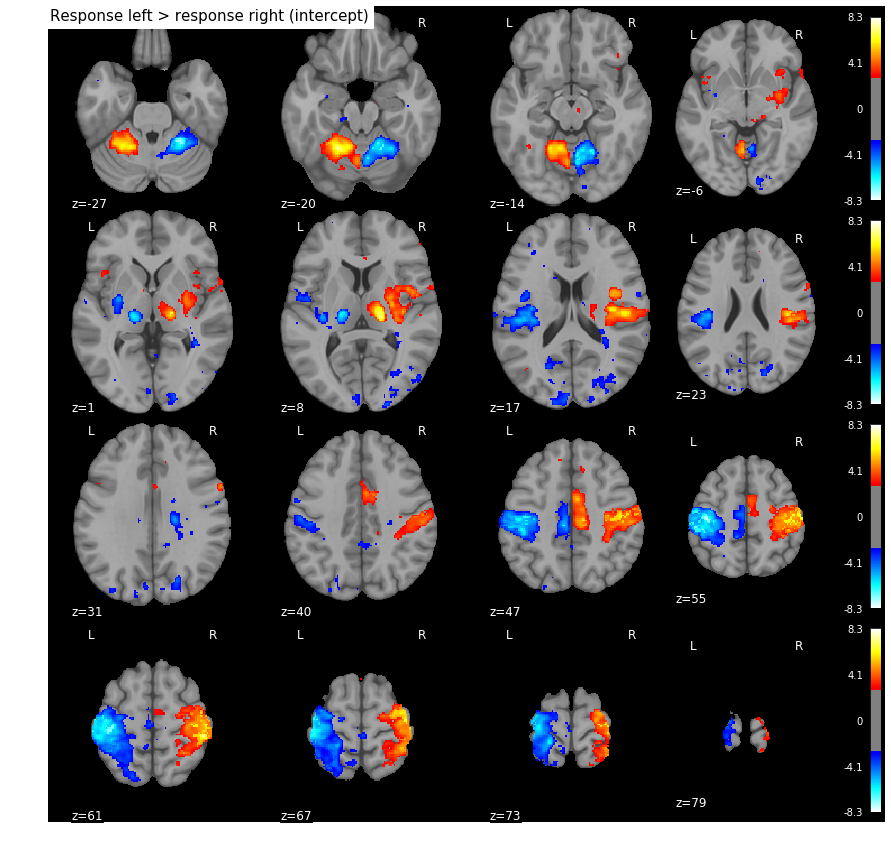

In [42]:
z_map_responselr_intercept, threshold = get_second_level_zmap('response_left - response_right', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, bg_img=mni09c, title='Response left > response right (intercept)')

##### Cluster-wise thresholding from FSL

"Significant" voxels were selected by thresholding with a z-value of 3.1 (p=0.001); then clusters were identified using a cluster-wise threshold of p=0.05

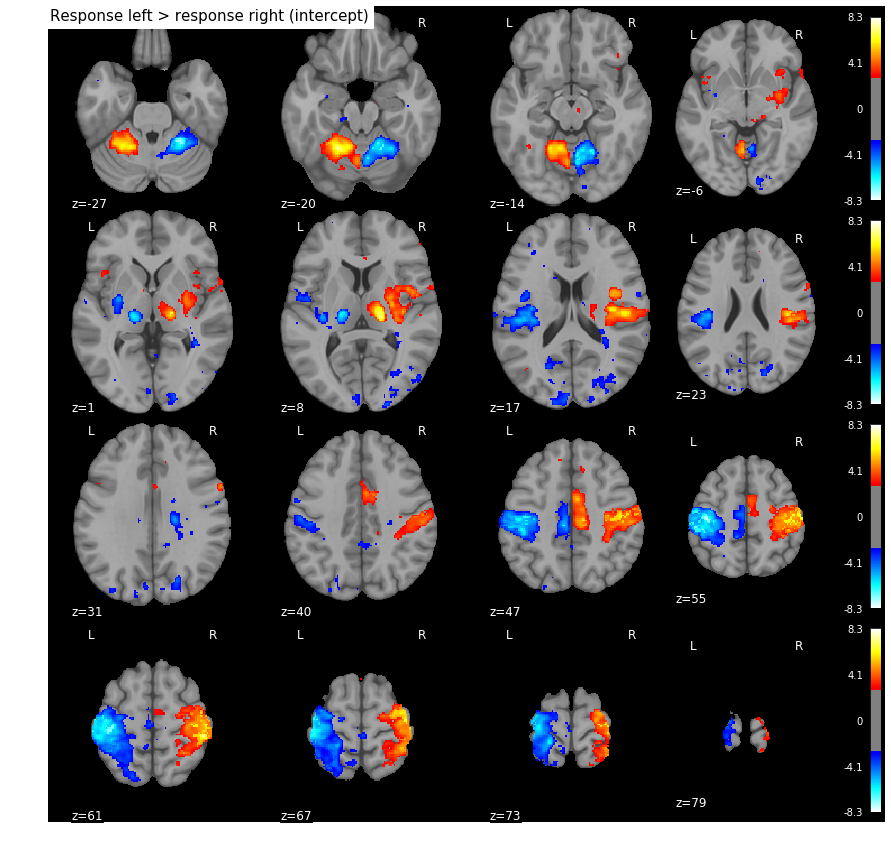

In [43]:
z_map_responselr_intercept_fwer, threshold = get_second_level_zmap('response_left - response_right', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_responselr_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Response left > response right (intercept)')

##### any difference between datasets here?

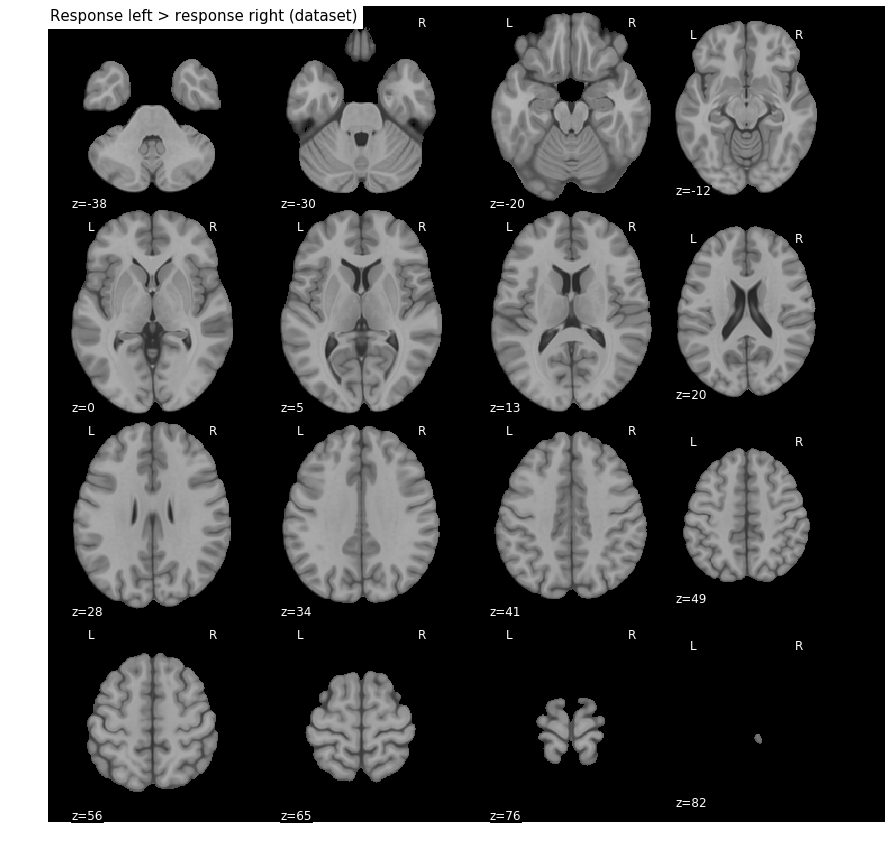

In [44]:
z_map_responselr_dataset, threshold = get_second_level_zmap('response_left - response_right', 'dataset', 'fdr')
f, ax = plot_4x4(z_map_responselr_dataset, threshold=threshold, bg_img=mni09c, title='Response left > response right (dataset)')

##### nothing significant, except there's a posterior-midbrain (thalamus?) increase in values in the Amsterdam data, and a small decrease in right cerebellum

## 2. Effect of error

##### FDR thresholding

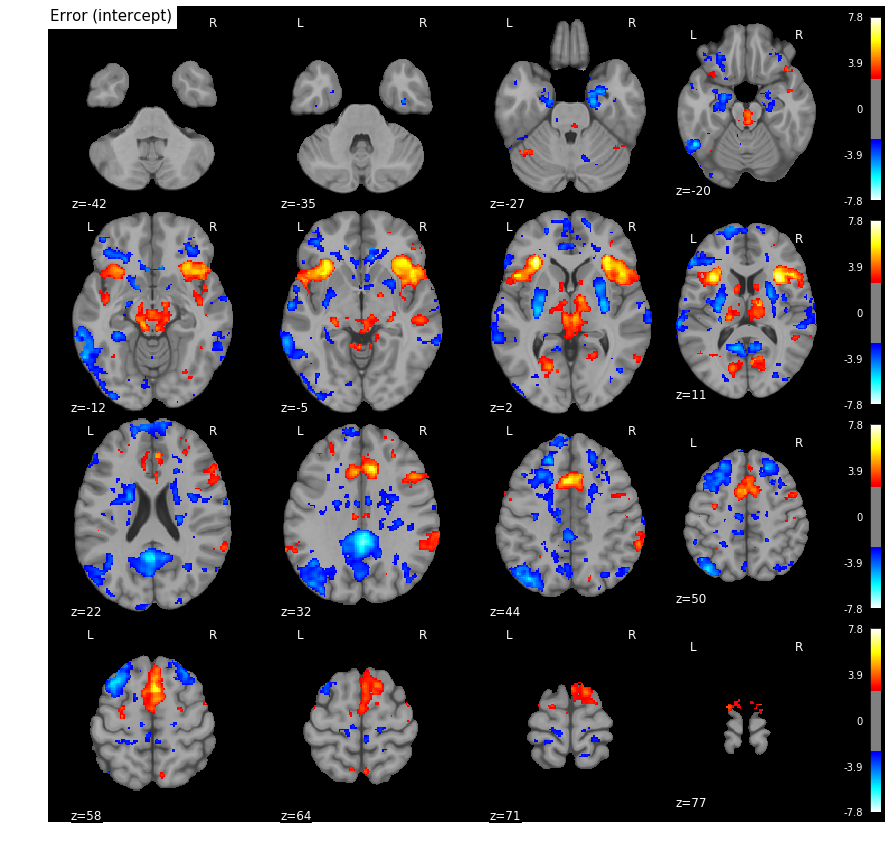

In [45]:
z_map_error_intercept, threshold = get_second_level_zmap('error', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_error_intercept, threshold=threshold, bg_img=mni09c, title='Error (intercept)')

#### FWER cluster thresholding

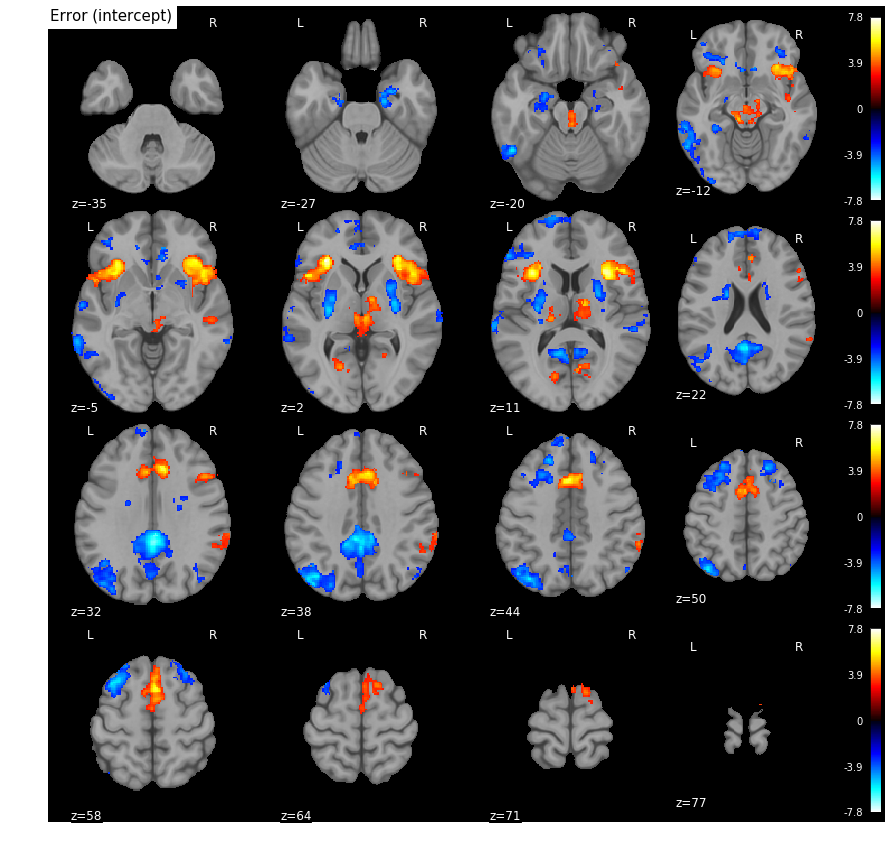

In [46]:
z_map_error_intercept_fwer, threshold = get_second_level_zmap('error', 'intercept', 'fwer')
f, ax = plot_4x4(z_map_error_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Error (intercept)')

It's a messy picture, but we see some positive clusters:
- "cognitive control"-related areas such as insula, and ACC
- prefrontal / premotor areas (preSMA? or even more frontal?) 
- Thalamus
- Some brain stem

And negative:
- A large negative cluster in visual areas that extends quite far superior
- Putamen

## Effect of cue payoff > cue neutral

First, check against second-level intercept

####  FDR

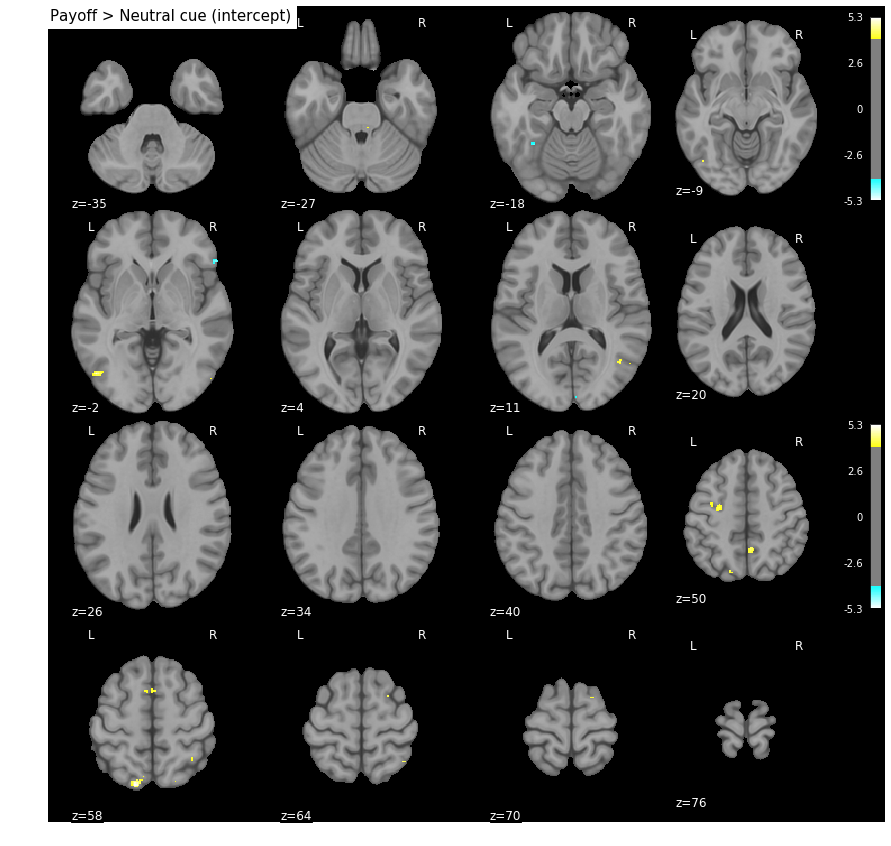

In [57]:
z_map_cue_intercept, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_cue_intercept, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (intercept)')

#### FWER cluster

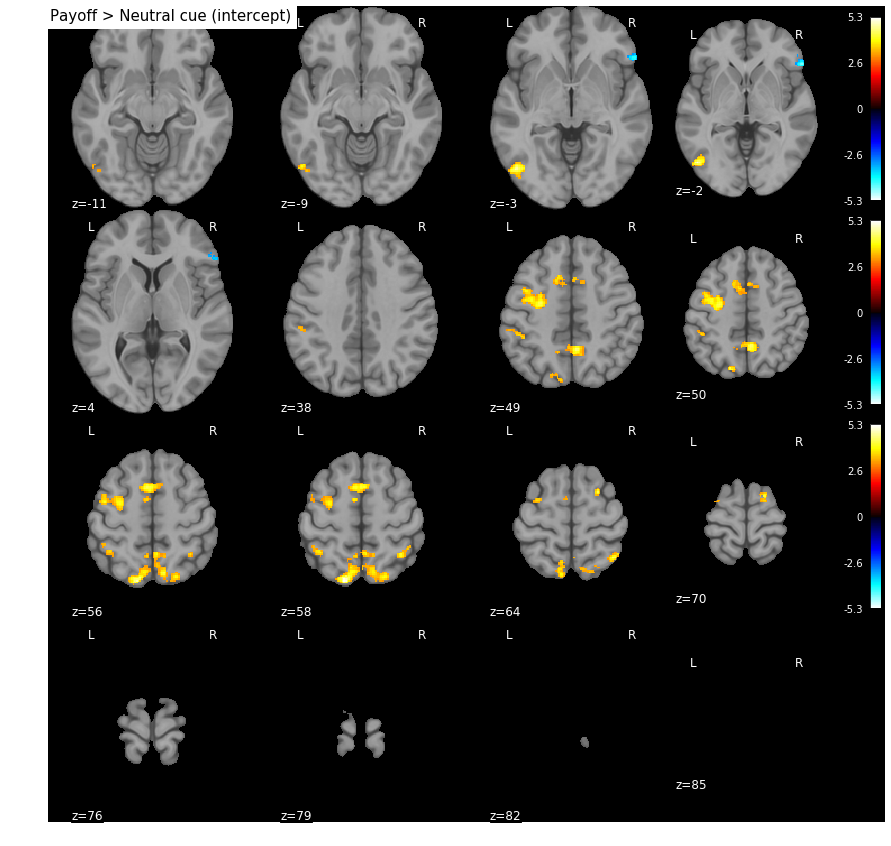

In [60]:
z_map_cue_intercept_fwer, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'intercept', 'fwer')
f, ax = plot_4x4(z_map_cue_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (intercept)')

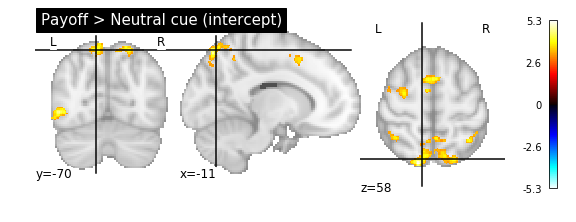

In [62]:
plotting.plot_stat_map(z_map_cue_intercept_fwer, title='Payoff > Neutral cue (intercept)')

##### So there seem to be some effects in parietal and visual cortex, and some frontal (pre-motor?) regions

### Against z-shift, no cluster survives

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f668cd1a4e0>,
       dtype=object))

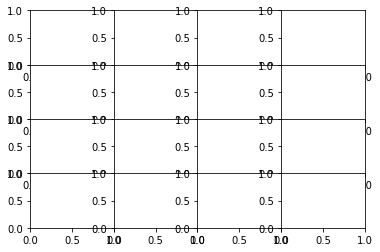

In [49]:
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'z_shift', 'fwer')
plot_4x4(z_map_cue_zshift, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (start point shift)')

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f66921f6710>,
       dtype=object))

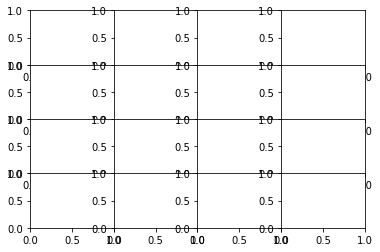

In [50]:
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'v_shift_bias', 'fwer')
plot_4x4(z_map_cue_zshift, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (drift bias shift)')

## Hard > Easy

(<Figure size 1080x1080 with 36 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f66920e54e0>,
       dtype=object))

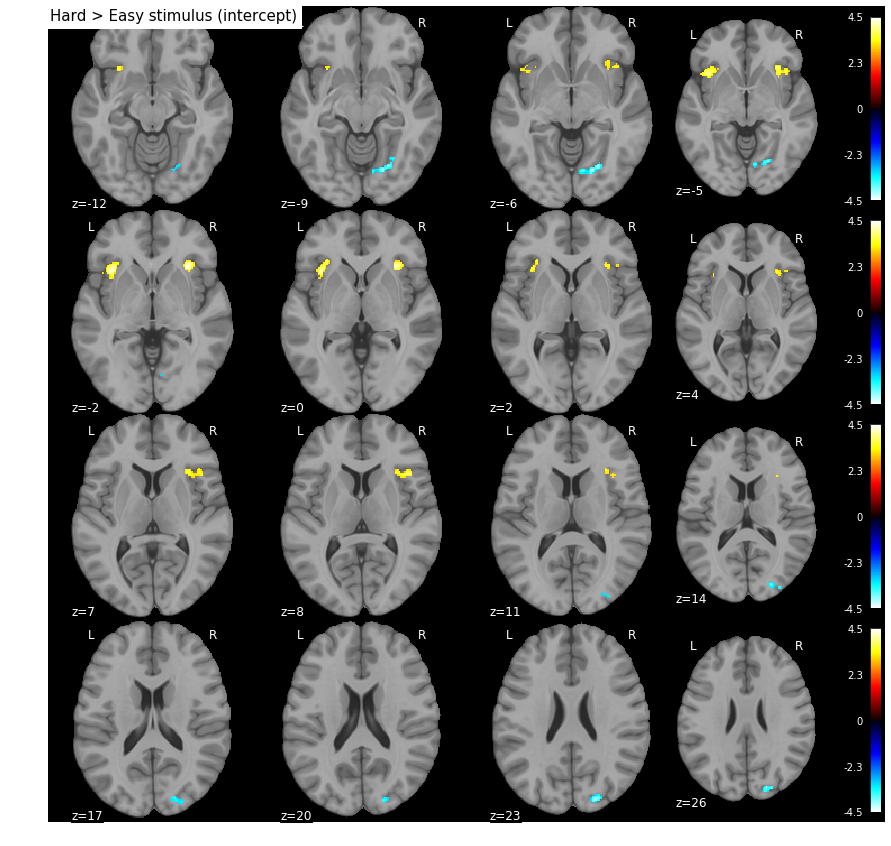

In [51]:
z_map_diff_intercept, threshold = get_second_level_zmap('stim_hard - stim_easy', 'intercept', 'fwer')
plot_4x4(z_map_diff_intercept, threshold=threshold, bg_img=mni09c, title='Hard > Easy stimulus (intercept)')

(<Figure size 1080x1080 with 34 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f668ac437f0>,
       dtype=object))

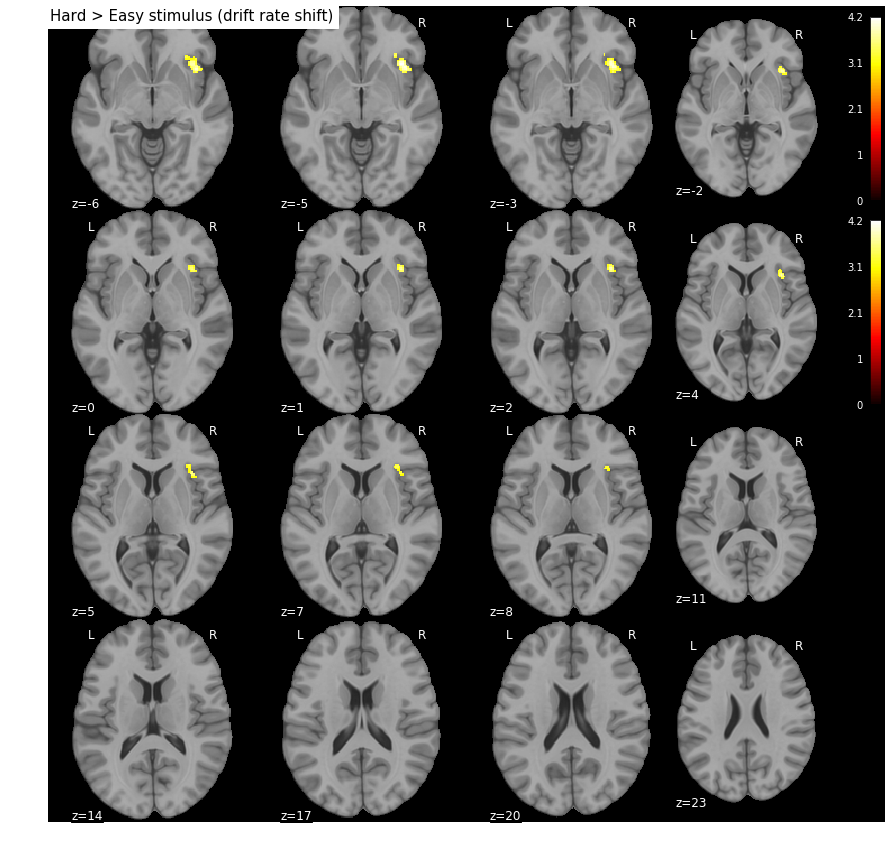

In [52]:
z_map_diff_vshift, threshold = get_second_level_zmap('stim_hard - stim_easy', 'v_shift', 'fwer')
plot_4x4(z_map_diff_vshift, threshold=threshold, bg_img=mni09c, title='Hard > Easy stimulus (drift rate shift)')

## Cue left - Cue right

(<Figure size 1080x1080 with 35 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f668a23e6a0>,
       dtype=object))

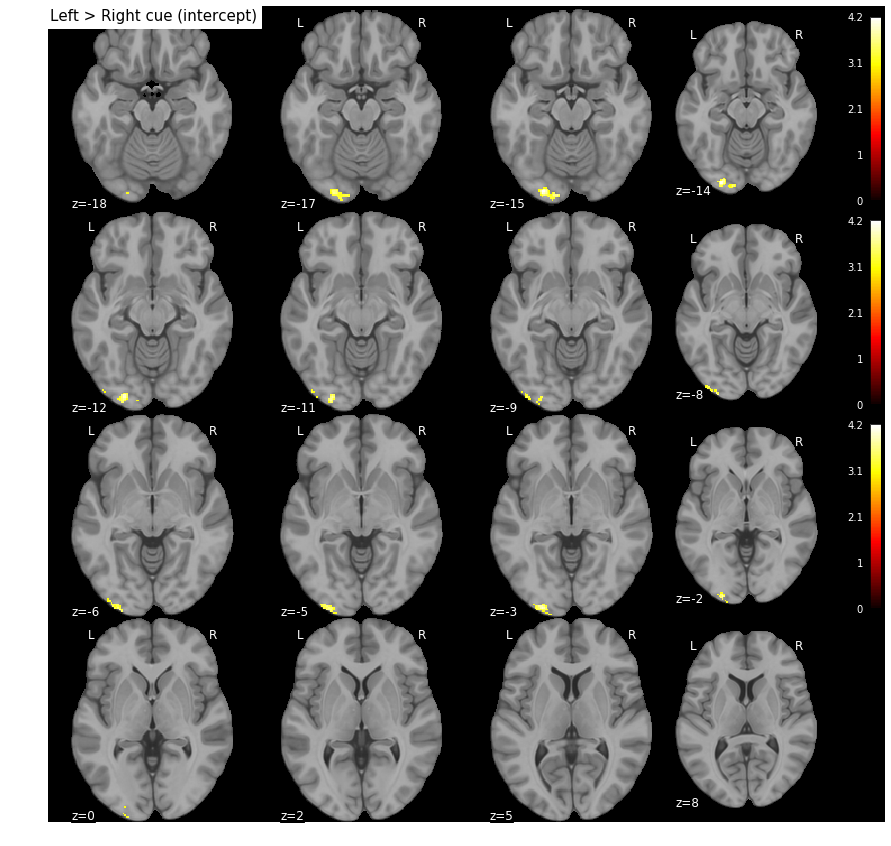

In [53]:
z_map_cuelr_intercept, threshold = get_second_level_zmap('cue_left - cue_right', 'intercept', 'fwer')
plot_4x4(z_map_cuelr_intercept, threshold=threshold, bg_img=mni09c, title='Left > Right cue (intercept)')

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6689864be0>,
       dtype=object))

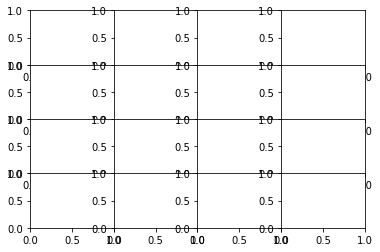

In [54]:
z_map_cuelr_zshift, threshold = get_second_level_zmap('cue_left - cue_right', 'z_shift', 'fwer')  # nothing
plot_4x4(z_map_cuelr_zshift, threshold=threshold, bg_img=mni09c, title='Left > Right cue (start point shift)')

In [55]:
z_map_cuelr_vshift, threshold = get_second_level_zmap('cue_left - cue_right', 'v_shift_drift', 'fwer')  # nothing
plot_4x4(z_map_cuelr_vshift, threshold=threshold, bg_img=mni09c, title='Left > Right cue (start point shift)')

KeyError: 'v_shift_drift'

In [1]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

%matplotlib inline

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 19

## Load first-levels

In [16]:
def get_sub_n(sub, max_sub_ds1=19):
    if sub > max_sub_ds1:
        sub -= max_sub_ds1
        ds = 2
    else:
        ds = 1
    return ds, sub

In [17]:
first_level_models = []
print('loading...', end='')
for sub in np.arange(1,35):
    if sub == 23:
        continue   # doesn't exist
    ds, sub = get_sub_n(sub)
    fn = './derivatives/ds-{:02d}/glm/first_level_models/sub-{}_glm.pkl'.format(ds, sub)

    if os.path.exists(fn):
        print(fn)
#        print('.', end='')
        with open(fn, 'rb') as f:
            model = pkl.load(f)
        first_level_models.append(model)
print('done, loaded {} models'.format(len(first_level_models)))

loading..../derivatives/ds-01/glm/first_level_models/sub-1_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-2_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-3_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-4_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-5_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-6_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-7_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-8_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-9_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-10_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-11_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-12_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-13_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-14_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-15_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-16_glm.pkl
./derivatives/ds-01/glm/first_level_models/sub-17_glm.pkl
./derivatives

# Second-level model:

Design matrix includes:
0. Intercept
1. Dataset (dummy coded)
2. Shift in start point
3. Shift in drift rate


- Second level intercept of left response > right response
- Second level contrast of shift in starting point on (left cue + right cue)/2 > neutral cue.
- Second level contrast of shift in starting point on left cue > right cue
- Second level contrast of shift in drift rate on hard trials > easy trials.

In [45]:
import pandas as pd
all_parameters = pd.read_pickle('./derivatives/all_subjectwise_parameters.pkl')
all_parameters = all_parameters[['ddm z_cue_regressor', 'ddm difficulty_effect']]
# all_parameters

design_matrix = pd.DataFrame([1] * all_parameters.shape[0], columns=['intercept'])
design_matrix['dataset'] = [0] * 19 + [1] * 14
design_matrix['z_shift'] = all_parameters['ddm z_cue_regressor'].values 
design_matrix['v_shift'] = all_parameters['ddm difficulty_effect'].values
design_matrix

intercept   z_shift   v_shift
0           1  0.028724  0.013665
1           1  0.014512  0.108871
2           1  0.011192  0.114586
3           1  0.025053 -0.048266
4           1  0.014188  0.257859
5           1  0.034346  0.365560
6           1  0.002007  0.210837
7           1  0.032026  0.191832
8           1  0.018179  0.317430
9           1  0.022719  0.088171
10          1  0.020894  0.040282
11          1  0.021409  0.297105
12          1  0.019744  0.017660
13          1  0.025900  0.138760
14          1  0.005385  0.947239
15          1  0.024216  0.313781
16          1  0.016236 -0.055171
17          1  0.018799  0.216572
18          1  0.030759  0.003779
19          1 -0.028161  0.685389
20          1  0.016783  0.639241
21          1  0.064586  0.103251
22          1  0.012176  0.504952
23          1  0.030557  1.418342
24          1  0.119840  1.005171
25          1  0.115714  2.237696
26          1  0.132330  0.687351
27          1  0.007351  0.538861
28          1  0.027987  0.409012
29          1 -0.032135  0.203056
30          1  0.233393  0.277192
31          1  0.090681  0.053855
32          1  0.031732  0.927566

In [22]:
glm = SecondLevelModel(smoothing_fwhm=0)  # data is already smoothed at first level
glm = glm.fit(first_level_models, design_matrix=design_matrix)

## Contrast 1: Left > Right response

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:587: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:587: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarn

3.5895686877208406


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


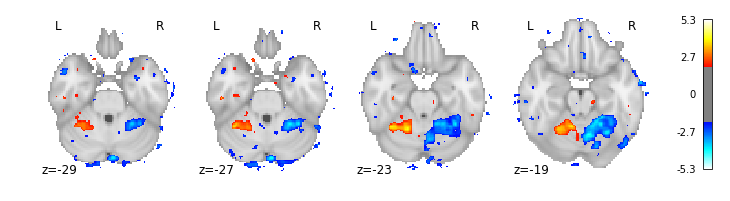

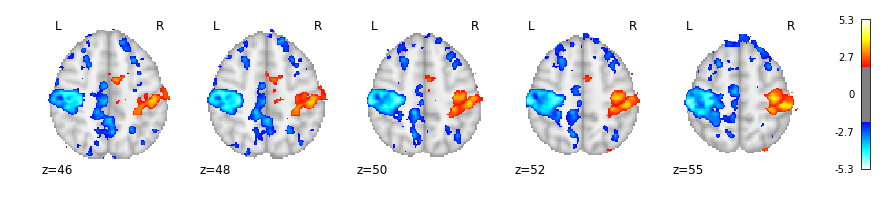

In [47]:
z1 = glm.compute_contrast(first_level_contrast='response_left - response_right', 
                          second_level_contrast='intercept', second_level_stat_type='t', output_type='z_score')

_, threshold = map_threshold(z1, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z1, display_mode='z', threshold=2, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z1, display_mode='z', threshold=2, cut_coords=[46, 48, 50, 52, 55])

4.655339196115573


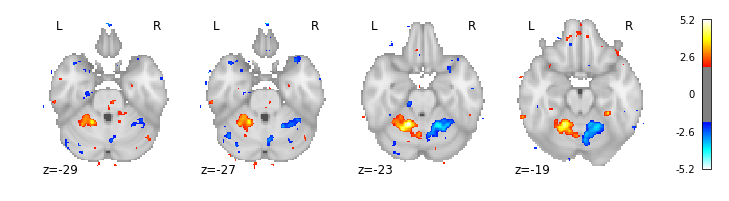

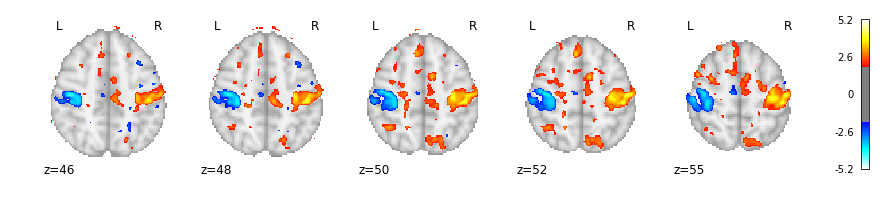

In [48]:
z1 = glm.compute_contrast(first_level_contrast='response_left_derivative - response_right_derivative', 
                          second_level_contrast='intercept', second_level_stat_type='t', output_type='z_score')

_, threshold = map_threshold(z1, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z1, display_mode='z', threshold=2, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z1, display_mode='z', threshold=2, cut_coords=[46, 48, 50, 52, 55])

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


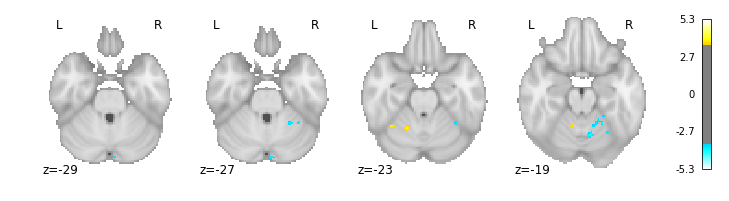

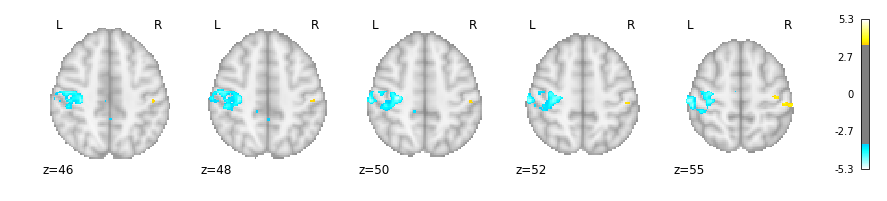

In [26]:
plot_stat_map(z1, display_mode='z', threshold=threshold, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z1, display_mode='z', threshold=threshold, cut_coords=[46, 48, 50, 52, 55])

## Contrast 2: Starting point shift on (left cue + right cue)/2 > neutral cue

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:587: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:587: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Converting to None (no smoothing option)
  .format(fwhm))


inf


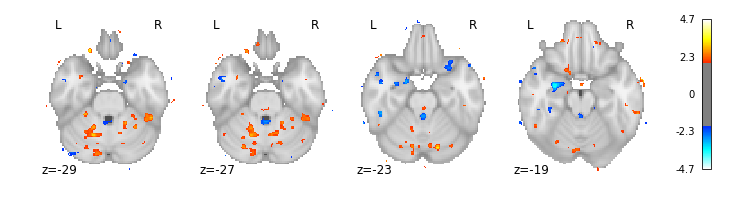

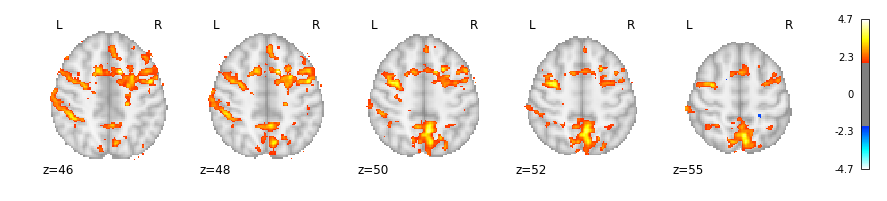

In [50]:
z2 = glm.compute_contrast(first_level_contrast='cue_left + cue_right - (2*cue_neutral)', 
                          second_level_contrast='intercept')

_, threshold = map_threshold(z2, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z2, display_mode='z', threshold=2, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z2, display_mode='z', threshold=2, cut_coords=[46, 48, 50, 52, 55])


# plot_stat_map(z2, display_mode='z', threshold=threshold, cut_coords=[-29, -27, -23, -19])
# plot_stat_map(z2, display_mode='z', threshold=threshold, cut_coords=[46, 48, 50, 52, 55])

In [ ]:
z2 = glm.compute_contrast(first_level_contrast='cue_left_derivative + cue_right_derivative - (2*cue_neutral_derivative)', 
                          second_level_contrast='intercept')

_, threshold = map_threshold(z2, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z2, display_mode='z', threshold=2, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z2, display_mode='z', threshold=2, cut_coords=[46, 48, 50, 52, 55])


# plot_stat_map(z2, display_mode='z', threshold=threshold, cut_coords=[-29, -27, -23, -19])
# plot_stat_map(z2, display_mode='z', threshold=threshold, cut_coords=[46, 48, 50, 52, 55])

inf


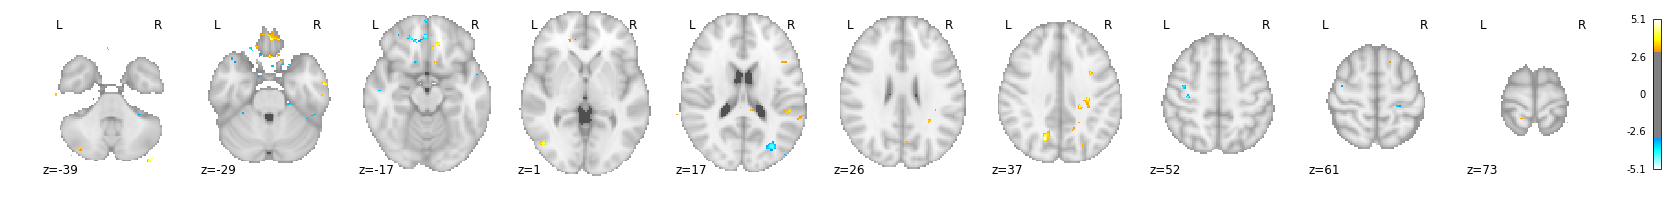

In [33]:
z2 = glm.compute_contrast(first_level_contrast='cue_left + cue_right - 2*cue_neutral', 
                          second_level_contrast='z_shift')

_, threshold = map_threshold(z2, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z2, display_mode='z', threshold=3, cut_coords=10)

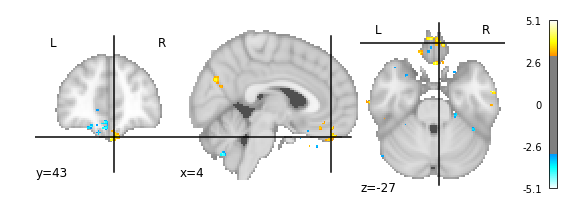

In [34]:
plot_stat_map(z2, display_mode='ortho', threshold=3)

## Drift rate

3.8784363493722864


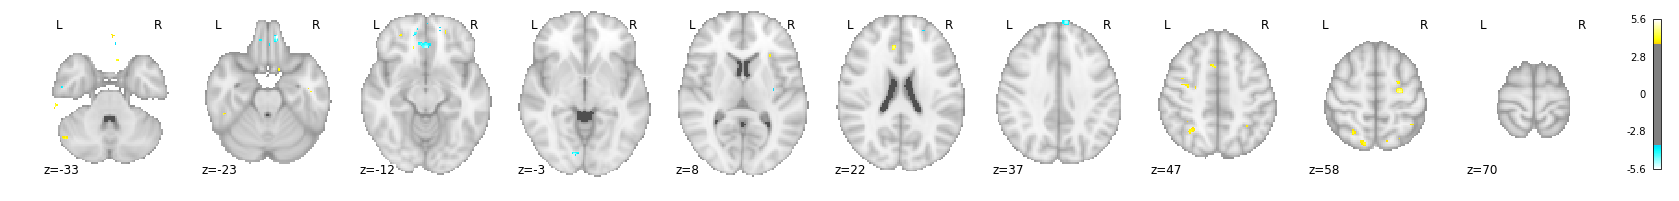

In [35]:
z3 = glm.compute_contrast(first_level_contrast='hard - easy', 
                          second_level_contrast='v_shift')

_, threshold = map_threshold(z3, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z3, display_mode='z', threshold=threshold, cut_coords=10)

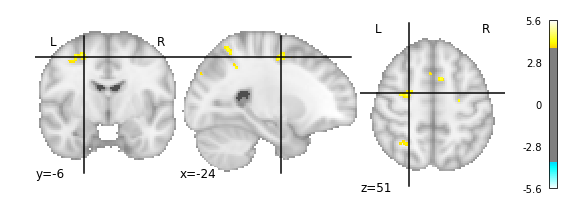

In [36]:
plot_stat_map(z3, display_mode='ortho', threshold=threshold)

inf


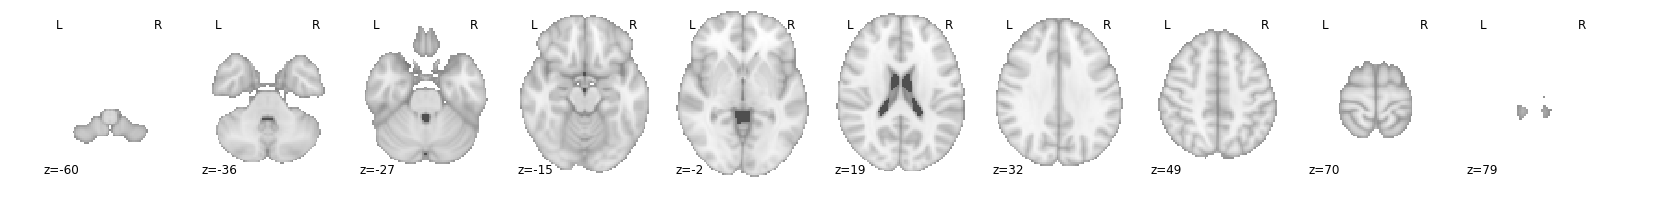

In [37]:
z4 = glm.compute_contrast(first_level_contrast='hard - easy', 
                          second_level_contrast='intercept')

_, threshold = map_threshold(z4, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z4, display_mode='z', threshold=threshold, cut_coords=10)

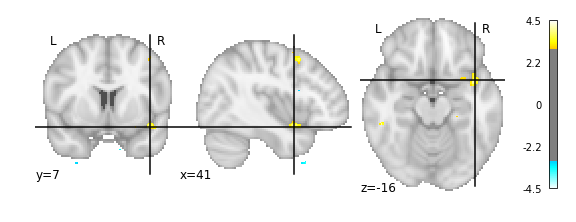

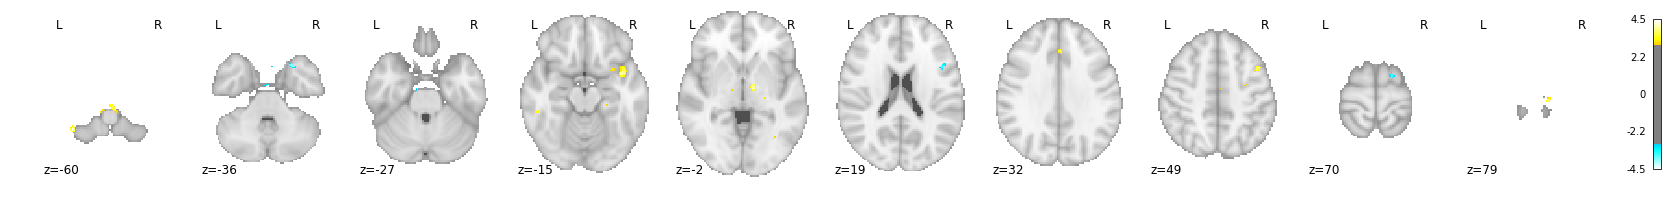

In [40]:
plot_stat_map(z4, display_mode='ortho', threshold=3)

plot_stat_map(z4, display_mode='z', threshold=3, cut_coords=10)

4.526028783300643


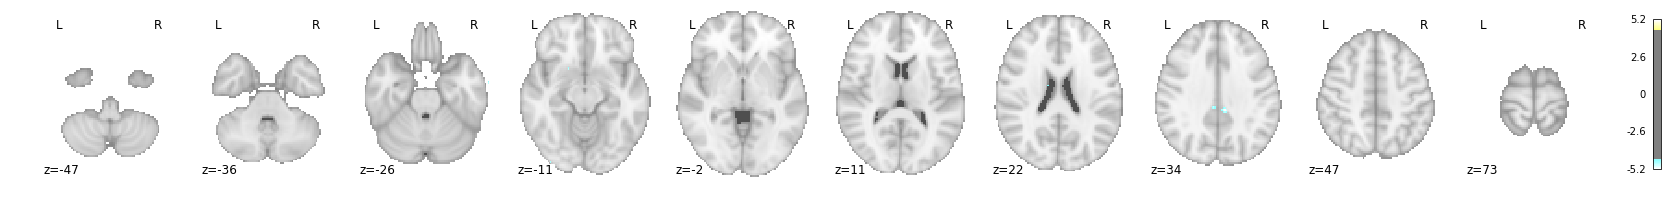

In [41]:
z5 = glm.compute_contrast(first_level_contrast='error', 
                          second_level_contrast='intercept')

_, threshold = map_threshold(z5, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z5, display_mode='z', threshold=threshold, cut_coords=10)

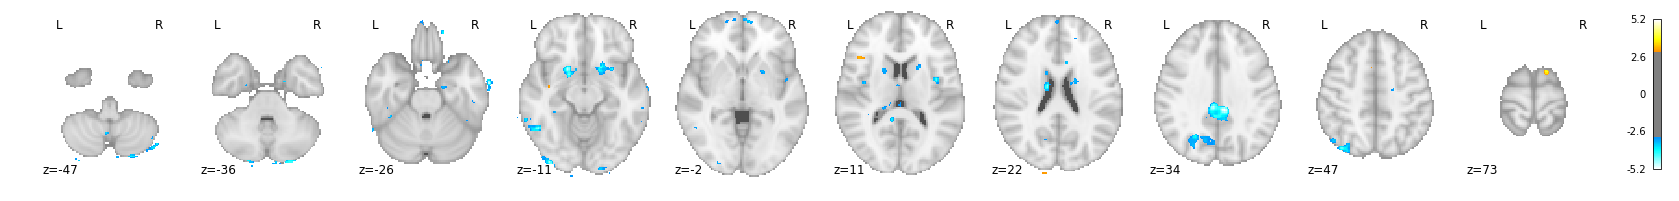

In [42]:
plot_stat_map(z5, display_mode='z', threshold=3, cut_coords=10)

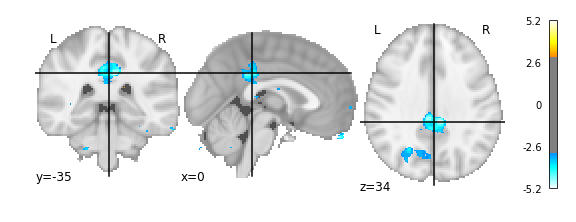

In [43]:
plot_stat_map(z5, display_mode='ortho', threshold=3)

3.9731484362726817


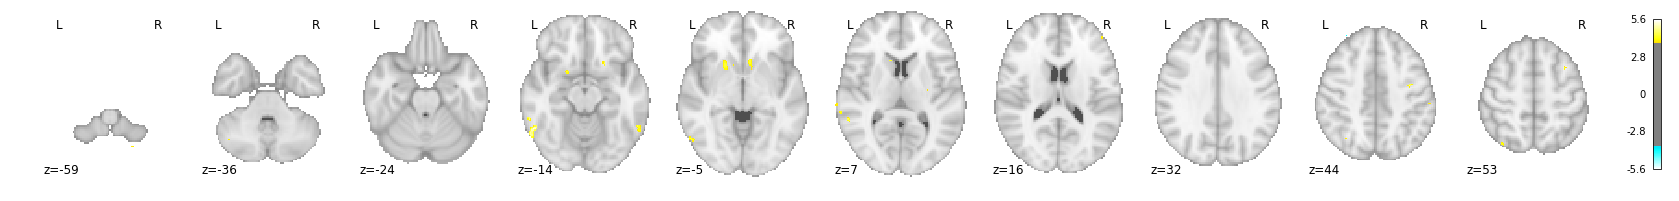

In [52]:
z6 = glm.compute_contrast(first_level_contrast='error_derivative', 
                          second_level_contrast='intercept')

_, threshold = map_threshold(z6, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z6, display_mode='z', threshold=threshold, cut_coords=10)